In [466]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast # Para converter strings de listas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import optuna

In [ ]:

# Leer y preparar los datos
df = pd.read_csv("./results_transformed_1000.csv")

up = df[df["val_iou"] > 0.8].sample(frac=0.15)
down = df[df["val_iou"] <= 0.8].sample(frac=1)
df = pd.concat([up, down], axis=0)

X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series).to_numpy()
X = np.nan_to_num(X, nan=-1)  # Reemplazar NaN por -1
y = df["val_iou"].to_numpy()

# Genera semilla para reproducibilidad
seed = np.random.randint(0, 100000)
print(f"Seed: {seed}")

Seed: 8656


C:\Users\Jafet\AppData\Local\Temp\ipykernel_18952\2821577855.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down["val_iou"] = -1


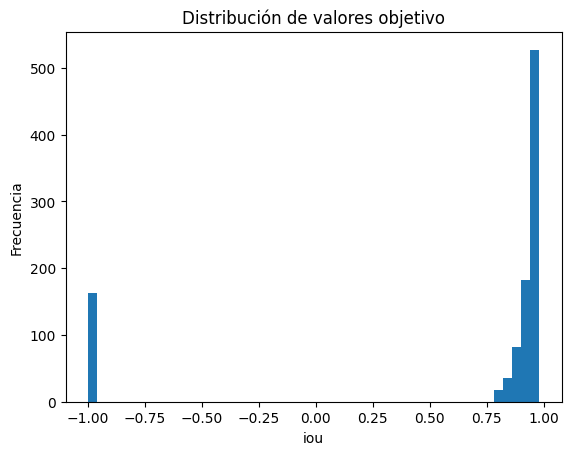

In [468]:
plt.hist(y, bins=50)
plt.title("Distribución de valores objetivo")
plt.xlabel("iou")
plt.ylabel("Frecuencia")
plt.show()

Graficas para los resultados

In [469]:
def paint_results(y_test, y_pred, order = True):
  # Grafica de la predicción y la realidad
  linespace = np.linspace(0, 1, y_pred.size)
  if order:
    # Ordena los pares test pred para que se vean mejor
    y_test, y_pred = zip(*sorted(zip(y_test, y_pred)))

  plt.plot(linespace, y_test, label="Real", marker="o")
  plt.plot(linespace, y_pred, label="Predicción", marker="x")
  plt.legend()
  plt.title("Real vs Predicción")
  plt.show()
  
def paint_real_vs_pred(y_test, y_pred):
  y_test = y_test.flatten()
  y_pred = y_pred.flatten()
  # Grafica de la predicción y la realidad
  plt.scatter(y_test, y_pred, marker="o")
  plt.xlabel("Real")
  plt.ylabel("Predicción")
  plt.title("Real vs Predicción")
  plt.show()
  # linealidad
  pearson = pearsonr(y_test, y_pred)[0]
  spearman = spearmanr(y_test, y_pred)[0]
  print(f"Pearson: {pearson:.4f}, Spearman: {spearman:.4f}")
  
def show_loss(train_losses, val_losses = None):
  plt.figure(figsize=(8,5))
  plt.plot(train_losses, label='Training Loss')
  if val_losses is not None:
    plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

## balanceo del dataset por bins

In [470]:
def balanced_dataset(df):
  # 1. Binear los valores del target para detectar frecuencia
  df['iou_bin'] = pd.qcut(df['iou'], q=10, duplicates='drop')  # o usa pd.cut

  # 2. Contar frecuencia de cada bin
  bin_counts = df['iou_bin'].value_counts().sort_index()

  # 3. Establecer umbral de frecuencia (por ejemplo, más de 10% del total)
  threshold = 0.05 * len(df)
  bins_to_downsample = bin_counts[bin_counts > threshold].index

  # 4. Submuestreo de los bins frecuentes
  df_balanced = pd.DataFrame()
  for b in df['iou_bin'].unique():
      bin_df = df[df['iou_bin'] == b]
      if b in bins_to_downsample:
          bin_df = bin_df.sample(frac=threshold / len(bin_df), random_state=42)  # downsampling
      df_balanced = pd.concat([df_balanced, bin_df])

  # 5. Eliminamos la columna auxiliar
  df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
  X_balanced = df_balanced.drop(['iou', 'iou_bin'], axis=1).values
  y_balanced = df_balanced['iou'].values
  
  return df_balanced

## Normalización

In [471]:
def select_scaler(tech:str = "minmax"):
  """ 
  Selecciona el escalador a usar. 0: StandardScaler, 1: MinMaxScaler
  """
  # Normaliza los datos
  if tech == "standar":
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()
  return scaler

scaler = select_scaler("minimax")
X = scaler.fit_transform(X)  # Normalizar X

## Reducción de dimensionalidades

In [472]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Definir el Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim)  # Capa comprimida
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Clase para fit_transform
class AutoencoderTransformer:
    def __init__(self, X, input_dim, hidden_dim=30, lr=0.001, num_epochs=300):
        """ 
        Inicializa el AutoencoderTransformer.
        input_dim: Dimensionalidad de entrada
        hidden_dim: Dimensionalidad de la capa comprimida
        lr: Tasa de aprendizaje
        num_epochs: Número de épocas para el entrenamiento
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.num_epochs = num_epochs
        self.autoencoder = Autoencoder(input_dim, hidden_dim)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.autoencoder.parameters(), lr=self.lr)
        self.fit(X)  # Entrenar el autoencoder al inicializar
        
    def fit(self, X):
        # Convertir a tensores
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Entrenar el autoencoder
        for epoch in range(self.num_epochs):
            self.autoencoder.train()
            self.optimizer.zero_grad()
            outputs = self.autoencoder(X_tensor)
            loss = self.criterion(outputs, X_tensor)
            loss.backward()
            self.optimizer.step()
    
    def transform(self, X):
        # Convertir a tensores
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.autoencoder.eval()
        with torch.no_grad():
            X_compressed = self.autoencoder.encoder(X_tensor).numpy()
        return X_compressed
    
    def fit_transform(self, X):
        return self.transform(X)


# Uso del Autoencoder para reducir dimensionalidad
autoencoder_transformer = AutoencoderTransformer(X, input_dim=X.shape[1], hidden_dim=30, lr=0.001, num_epochs=400)

# Ajustar y transformar los datos
X_reduced = autoencoder_transformer.fit_transform(X)

# Ver el resultado
print(f"Dimensionalidad comprimida: {X_reduced.shape[1]}")
print(f"Dimensionalidad original: {X.shape[1]}")

Dimensionalidad comprimida: 30
Dimensionalidad original: 62


In [473]:
def select_get_features(tech:str = "pca", seed:int = 42, k = 33):
  """ 
  Selecciona el número de características a usar
  tech: "pca", "kbeast" o "autoencoder"
  seed: Semilla para reproducibilidad
  k: Número de características a seleccionar (para kbeast)
  """
  selector = PCA(n_components=0.95, random_state=seed)
  if tech == "kbeast":
    selector = SelectKBest(score_func=f_regression, k=k)
  elif tech == "pca":
    selector = PCA(n_components=0.95, random_state=seed)  # Mantener el 95% de la varianza
  elif tech == "autoencoder":
    selector = autoencoder_transformer
  return selector

selector = select_get_features("autoencoder", seed)
X = selector.fit_transform(X)  # Seleccionar características

print(f"Dimensionalidad original: {df['real_codification'].apply(ast.literal_eval).apply(pd.Series).shape[1]}")
print(f"Dimensionalidad reducida: {X.shape[1]}")

Dimensionalidad original: 62
Dimensionalidad reducida: 30


## MLP Entrenamiento y validación

K-Fold CV, early stopping y scheduler de learning rate

In [474]:
class MLP(nn.Module):
  def __init__(self, input_dim):
    super(MLP, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(input_dim, 128),
      nn.ReLU(),
      nn.Dropout(0.4),
      
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(0.3),
      
      nn.Linear(64, 1)
    )
  
  def forward(self, x):
    return self.model(x)
  
def weighted_mse_loss(output, target, thresh=0.5):
    # creamos un weight por cada elemento del batch
    w = torch.where(target < thresh,
                    torch.tensor(3.0, device=target.device),
                    torch.tensor(1.0, device=target.device))
    # mse sin reducción, luego aplicamos pesos y hacemos mean
    return torch.mean(w * (output - target)**2)

""" df = pd.read_csv("./results_transformed.csv")
df = balanced_dataset(df)
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series).to_numpy()
X = np.nan_to_num(X, nan=-1)  # Reemplazar NaN por -1
y = df["iou"].to_numpy()

# Normalizar los datos
scaler = select_scaler("standar")
X = scaler.fit_transform(X)  # Normalizar X
X = select_get_features("autoencoder").fit_transform(X)  # Seleccionar características """
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Creamos un DataLoader para el conjunto de entrenamiento
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Inicializa modelo, perdida y optimizador
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

best_loss = float('inf')
patience = 50
counter = 0
best_model_wts = None
l1_lambda = 1e-5

# Entrenamiento del modelo
num_epochs = 500
train_losses = []
val_losses = []
for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  for inputs, target in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, target)
    #loss = weighted_mse_loss(outputs, target)  # Usar la función de pérdida personalizada
    l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
    loss = loss + l1_lambda * l1_penalty  # Añadir la penalización L1 a la pérdida
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
  train_losses.append(total_loss / len(train_loader))
  
  model.eval()
  total_test_loss = 0
  with torch.no_grad():
    for inputs, target in test_loader:
      outputs = model(inputs)
      loss = criterion(outputs, target)
      #loss = weighted_mse_loss(outputs, target)  # Usar la función de pérdida personalizada
      total_test_loss += loss.item()
  val_loss = total_test_loss / len(test_loader)
  val_losses.append(val_loss)
  
  scheduler.step(val_loss)  # Actualiza el learning rate
  
  # Early stopping
  if val_loss < best_loss:
    best_loss = val_loss
    counter = 0
    best_model_wts = model.state_dict() # Guardar los mejores pesos
  else:
    counter += 1
    if counter >= patience:
      print("Early stopping at epoch", epoch + 1)
      break
  # Mostrar el progreso cada 10 épocas
  if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")
    
# Cargar los mejores pesos
model.load_state_dict(best_model_wts)
# Guardar el modelo
torch.save(model.state_dict(), "best_model.pth")
# Evaluación del modelo
model.eval()
with torch.no_grad():
  y_pred = model(X_test_tensor).numpy()
  
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

c:\Users\Jafet\Documents\Escuela-Estudio\TT\NAS\NASENV\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [10/500], Loss: 0.5475384363761315, Val Loss: 0.397179656795093
Epoch [20/500], Loss: 0.5441250640612382, Val Loss: 0.41797383981091635
Epoch [30/500], Loss: 0.5068504833258115, Val Loss: 0.39655776960509165
Epoch [40/500], Loss: 0.48231714562727857, Val Loss: 0.3727880822760718
Epoch [50/500], Loss: 0.474147970859821, Val Loss: 0.3656879588961601
Epoch [60/500], Loss: 0.4627848078425114, Val Loss: 0.38085584342479706
Epoch [70/500], Loss: 0.41108980431006503, Val Loss: 0.37572924154145376
Epoch [80/500], Loss: 0.4037743927194522, Val Loss: 0.3710597263915198
Epoch [90/500], Loss: 0.39097612179242647, Val Loss: 0.39856058784893583
Epoch [100/500], Loss: 0.3503826673214252, Val Loss: 0.3800956585577556
Epoch [110/500], Loss: 0.3458507267328409, Val Loss: 0.3820434457489422
Early stopping at epoch 112
MAE: 0.4125
R2: -0.1183
MSE: 0.4241
RMSE: 0.6513


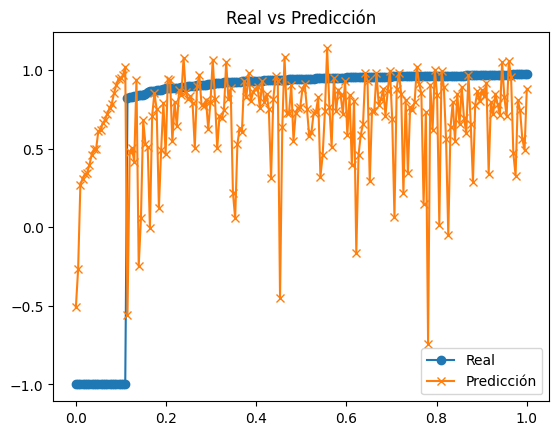

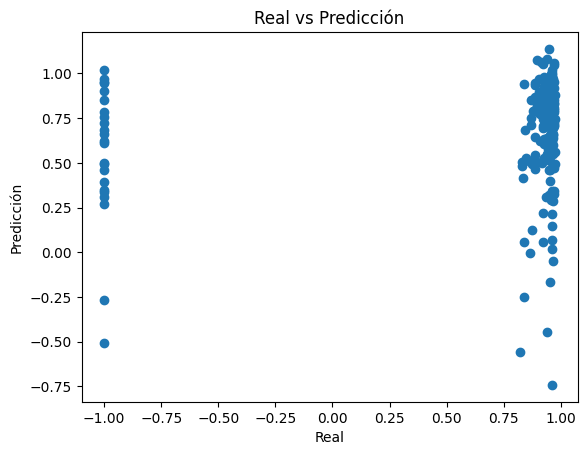

Pearson: 0.1419, Spearman: 0.1304


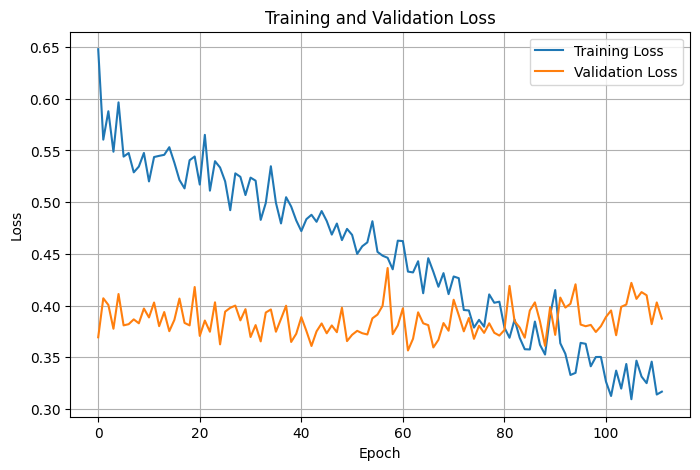

In [475]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)
show_loss(train_losses, val_losses)

## Ajuste de hiperparametros automaticos

In [476]:
def select_scheduler(scheduler:str = "step", optimizer = None):
  """ 
  Selecciona el scheduler a usar. 
  step: StepLR, reduce: ReduceLROnPlateau, cosine: CosineAnnealingLR
  """
  if scheduler == "step":
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
  elif scheduler == "reduce":
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=20)
  elif scheduler == "cosine":
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
  return scheduler

def train_model(X, y, normalization_model:str = "minmax", feauters_model:str = "pca", scheduler_name:str = "step", lr:float = 1e-3, weight_decay:float = 1e-6, verbose:bool = True):
  # Normaliza
  scaler = select_scaler(normalization_model)
  X = scaler.fit_transform(X)  # Normalizar X
  # Selecciona características
  selector = select_get_features(feauters_model, seed)
  X = selector.fit_transform(X, y) if feauters_model == "kbeast" else selector.fit_transform(X)  # Seleccionar características
  
  # Dividir los datos en conjuntos de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
  # Convertir a tensores
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
  # Crea un DataLoader para el conjunto de entrenamiento
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
  
  # Inicializa modelo, perdida y optimizador
  model = MLP(input_dim=X_train.shape[1])
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  scheduler = select_scheduler(scheduler_name, optimizer)
  
  best_loss = float('inf')
  patience = 100
  counter = 0
  best_model_wts = None
  
  # Entrenamiento del modelo
  num_epochs = 600
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, target in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
      for inputs, target in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, target)
        total_test_loss += loss.item()
    val_loss = total_test_loss / len(test_loader)
    val_losses.append(val_loss)
    
    if scheduler_name == "reduce":
      scheduler.step(val_loss)
    else:
      scheduler.step()
    
    # Early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      counter = 0
      best_model_wts = model.state_dict() # Guardar los mejores pesos
    else:
      counter += 1
      if counter >= patience:
        print("Early stopping at epoch", epoch + 1)
        break
    # Mostrar el progreso cada 10 épocas
    if (epoch + 1) % 10 == 0 and verbose:
      print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")
      
  # Evaluación del modelo
  model.eval()
  with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
      
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  # Muestra resultados
  if verbose:
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {np.sqrt(mse):.4f}")
    
    # Grafica de la predicción y la realidad
    paint_results(y_test, y_pred, order=True)
    paint_real_vs_pred(y_test, y_pred)
    show_loss(train_losses, val_losses)
  
  return mse, r2

def objective(trial):
  # Espacio de búsqueda
  normalization_model = trial.suggest_categorical("normalization_model", ["minmax", "standard"])
  feauters_model = trial.suggest_categorical("feauters_model", ["pca", "kbest", "autoencoder"])
  scheduler_name = trial.suggest_categorical("scheduler", ["step", "reduce", "cosine"])
  lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
  weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
  
  # Leer y preparar los datos
  df = pd.read_csv("./results_transformed_1000.csv")
  X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series).to_numpy()
  X = np.nan_to_num(X, nan=-1)  # Reemplazar NaN por -1
  y = df["val_iou"].to_numpy()
  
  mse, r2 = train_model(X, y, normalization_model, feauters_model, scheduler_name, lr, weight_decay, verbose=False)
  return mse, r2  # Devolvemos el error cuadrático medio como métrica de evaluación

In [477]:
# Crear un estudio de Optuna
study = optuna.create_study(directions=["minimize", "maximize"])
study.optimize(objective, n_trials=5)  # Número de pruebas a realizar

for trial in study.best_trials:
    print("Trial number: ", trial.number)
    print("Best parameters: ", trial.params)
    print("Best value: ", trial.values)
    print("Best value (mse): ", trial.values[0])
    print("Best value (r2): ", trial.values[1])

[I 2025-05-10 14:54:56,364] A new study created in memory with name: no-name-e500719c-2df9-47f4-b99a-909be630271d
[W 2025-05-10 14:54:59,670] Trial 0 failed with parameters: {'normalization_model': 'standard', 'feauters_model': 'autoencoder', 'scheduler': 'reduce', 'lr': 0.0020976373578011345, 'weight_decay': 0.005098449393856039} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Jafet\Documents\Escuela-Estudio\TT\NAS\NASENV\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Jafet\AppData\Local\Temp\ipykernel_18952\2618428031.py", line 127, in objective
    mse, r2 = train_model(X, y, normalization_model, feauters_model, scheduler_name, lr, weight_decay, verbose=False)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jafet\AppData\Local\Temp\ipy

KeyboardInterrupt: 

In [ ]:
params = study.best_trials[0].params
train_model(
  X,
  y,
  normalization_model=params["normalization_model"],
  feauters_model=params["feauters_model"],
  scheduler_name=params["scheduler"],
  lr=params["lr"],
  weight_decay=params["weight_decay"],
  verbose=True
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1008x30 and 62x128)

## Red neuronal convolucional

In [ ]:
# -------------------------------------------------------------------
#   1) Definimos la CNN para regresión
# -------------------------------------------------------------------
class CNNRegressor(nn.Module):
    def __init__(self, input_length):
        super().__init__()
        # Bloques convolucionales que van reduciendo la longitud por 2 cada vez
        # input: (batch, 1, 62)
        self.features = nn.Sequential(
            nn.Conv1d(1,  64, kernel_size=3, stride=2, padding=1),  # → (batch,64,31)
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),  # → (batch,128,16)
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1), # → (batch,256,8)
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1), # → (batch,512,4)
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(512, 1024, kernel_size=3, stride=2, padding=1), # → (batch,512,2)
            nn.ReLU(),
        )
        # Capa fully-connected final (flatten + MLP pequeño)
        # 512 canales × 4 posiciones = 2048
        self.regressor = nn.Sequential(
            nn.Flatten(),                        
            nn.Linear(1024 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(16, 1)  # Salida continua
        )

    def forward(self, x):
        # x: (batch, 62) → (batch, 1, 62)
        x = x.unsqueeze(1)
        x = self.features(x)
        x = self.regressor(x)
        return x
      
# -------------------------------------------------------------------
#   2) Preparar datos y DataLoaders
# -------------------------------------------------------------------
""" df = pd.read_csv("./results_transformed.csv")
df = balanced_dataset(df)
X = df["real_codification"].apply(ast.literal_eval).apply(pd.Series).to_numpy()
X = np.nan_to_num(X, nan=-1)  # Reemplazar NaN por -1
y = df["iou"].to_numpy()
 """
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# Tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

# DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),  batch_size=32, shuffle=False
)

# -------------------------------------------------------------------
#   3) Entrenamiento y evaluación
# -------------------------------------------------------------------
model     = CNNRegressor(input_length=62)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=30, verbose=True
)
criterion = nn.MSELoss()

best_loss     = float('inf')
patience      = 200
counter       = 0
best_model_wt = None

num_epochs = 1000
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, target in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for inputs, target in test_loader:
            outputs = model(inputs)
            running_val += criterion(outputs, target).item()
    val_loss = running_val / len(test_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss     = val_loss
        counter       = 0
        best_model_wt = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch", epoch+1)
            break

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {train_losses[-1]:.4f}  "
              f"Val Loss:   {val_losses[-1]:.4f}")

# Cargar mejores pesos y evaluar
model.load_state_dict(best_model_wt)
# Guardar el modelo
torch.save(model.state_dict(), "best_model_cnn.pth")
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy()

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

c:\Users\Jafet\Documents\Escuela-Estudio\TT\NAS\NASENV\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/1000]  Train Loss: 0.0740  Val Loss:   0.0623
Epoch [20/1000]  Train Loss: 0.0572  Val Loss:   0.0477
Epoch [30/1000]  Train Loss: 0.0505  Val Loss:   0.0619
Epoch [40/1000]  Train Loss: 0.0359  Val Loss:   0.0573
Epoch [50/1000]  Train Loss: 0.0274  Val Loss:   0.0598
Epoch [60/1000]  Train Loss: 0.0201  Val Loss:   0.0569
Epoch [70/1000]  Train Loss: 0.0185  Val Loss:   0.0567
Epoch [80/1000]  Train Loss: 0.0168  Val Loss:   0.0502
Epoch [90/1000]  Train Loss: 0.0152  Val Loss:   0.0545
Epoch [100/1000]  Train Loss: 0.0115  Val Loss:   0.0545
Epoch [110/1000]  Train Loss: 0.0101  Val Loss:   0.0571
Epoch [120/1000]  Train Loss: 0.0100  Val Loss:   0.0549
Epoch [130/1000]  Train Loss: 0.0108  Val Loss:   0.0529
Epoch [140/1000]  Train Loss: 0.0108  Val Loss:   0.0587
Epoch [150/1000]  Train Loss: 0.0090  Val Loss:   0.0559
Epoch [160/1000]  Train Loss: 0.0095  Val Loss:   0.0616
Epoch [170/1000]  Train Loss: 0.0086  Val Loss:   0.0632
Epoch [180/1000]  Train Loss: 0.0072  Va

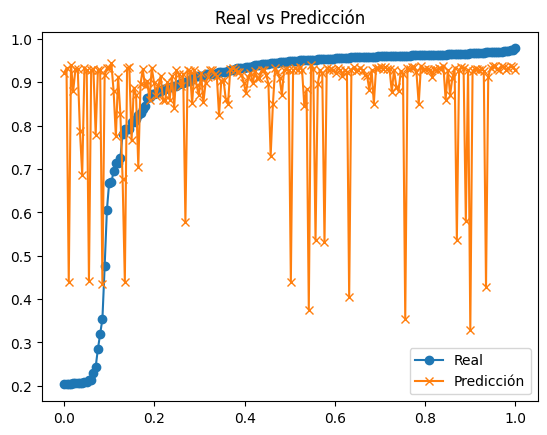

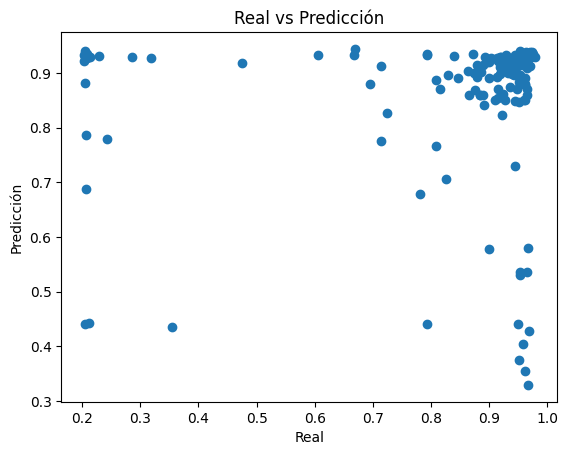

Pearson: 0.1379, Spearman: 0.3163


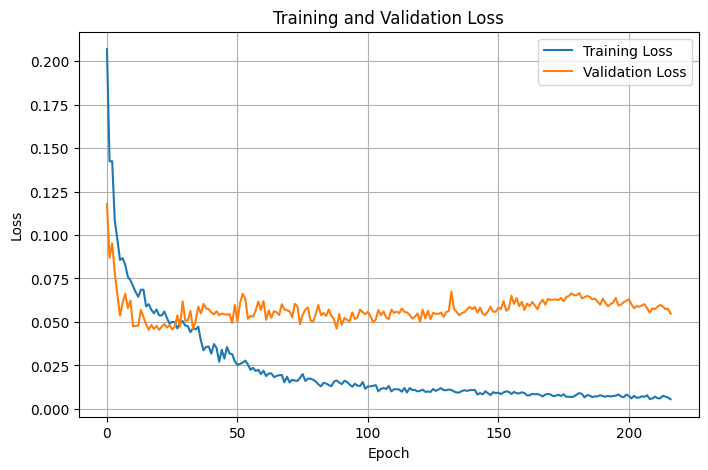

In [ ]:
# Grafica de la predicción y la realidad
paint_results(y_test, y_pred, order=True)
paint_real_vs_pred(y_test, y_pred)
show_loss(train_losses, val_losses)